## Load the model from Hugging Face Hub:

In [3]:
import os, requests, torch, transformers, warnings
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from io import BytesIO
from torchvision.utils import make_grid

ckpt_name = 'aehrc/cxrmate-multi-tf'

dataset_dir = '/datasets/work/hb-mlaifsp-mm/work/datasets'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder_decoder = transformers.AutoModel.from_pretrained(ckpt_name, trust_remote_code=True).to(device)
encoder_decoder.eval()
tokenizer = transformers.PreTrainedTokenizerFast.from_pretrained(ckpt_name)
image_processor = transformers.AutoFeatureExtractor.from_pretrained(ckpt_name)

test_transforms = transforms.Compose(
    [
        transforms.Resize(size=image_processor.size['shortest_edge']),
        transforms.CenterCrop(size=[
            image_processor.size['shortest_edge'],
            image_processor.size['shortest_edge'],
        ]
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=image_processor.image_mean,
            std=image_processor.image_std,
        ),
    ]
)

## The images for the study of each patient:

In [4]:
# Images from study of Patient 1:
image_1 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/4a5283d6-157b6054-3840ea3d-d27e7ba1-d6689022.jpg'))
image_1 = image_1.convert('RGB')

image_2 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p13/p13475033/s54028344/7794e4cb-719a0b85-18532575-0b5ea119-8eb26b6a.jpg'))
image_2 = image_2.convert('RGB')

# Images from study from Patient 2:
image_3 = Image.open(os.path.join(dataset_dir, 'physionet.org/files/mimic-cxr-jpg/2.0.0/files/p15/p15131736/s57531802/308bf948-d05f2a1d-2c32a818-2df09584-d17283f6.jpg'))
image_3 = image_3.convert('RGB')

image_1 = test_transforms(image_1)
image_2 = test_transforms(image_2)
image_3 = test_transforms(image_3)

study_a = torch.stack([image_1, image_2], dim=0)
study_b = torch.stack([image_3], dim=0)

images = torch.nn.utils.rnn.pad_sequence([study_a, study_b], batch_first=True, padding_value=0.0)
images.shape

torch.Size([2, 2, 3, 384, 384])

### Images from all of the studies:

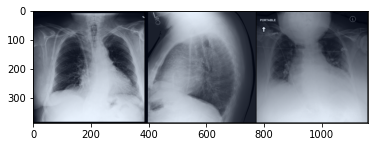

In [5]:
display_images = torch.stack([image_1, image_2, image_3], dim=0)
plt.imshow(make_grid(display_images, normalize=True).permute(1, 2, 0))

## Generate the reports:

In [7]:
outputs = encoder_decoder.generate(
    pixel_values=images.to(device),
    special_token_ids=[tokenizer.sep_token_id],
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    return_dict_in_generate=True,
    use_cache=True,
    max_length=256,
    num_beams=4,
)
outputs.sequences

tensor([[   1,  846,  148,  369,  546,  132,  115,  250,  725,  792,   23, 1916,
         3976,  182,   22,  580,  732,  816,  535,  739,  282,  115, 1204,  820,
           24, 6473,  182,  878,   23,  213,  120, 1093,  988,  125,  626, 1074,
         1157,  515,  519,  233,  625,  197,  875,  193,  795,   21, 1025,  106,
         1540,  132, 1147,  355,  626,  280,  120,  454,  790,   23,  198,  183,
          171,  214,  211,  120,  269,   23,  139,  375,  148,  356,  800,  150,
          402,   23,    3, 2159,  626, 1074, 1157,  519,  233,  625,  197,  875,
          193,  795,   21, 1025,  106, 1540,  132,  355,  626,  280,  120,  454,
          790,   23,    2],
        [   1,  127,  193,  405,  150,  265,   23,  139,  428,  120,  355,   22,
         1194,   22, 5071,  564,   23, 2383,  400, 1615,  125, 1361,   21,  115,
          356,  148,  386,  349,  370,  296,   23,  139,  342,  370,  303,   23,
          213,  150,  163,  183,  374,  214,  211,   23,    3, 1784,  475,   23,


## Decode using the tokenizer:

In [8]:
# Findings and impression sections (exclude previous impression section):
findings, impression = encoder_decoder.split_and_decode_sections(
    outputs.sequences,
    [tokenizer.sep_token_id, tokenizer.eos_token_id],
    tokenizer,
)
for i, j in zip(findings, impression):
    print(f'Findings: {i}\nImpression: {j}\n')

Findings: Frontal and lateral views of the chest were obtained. Large bore right-sided central venous catheter terminates at the cavoatrial junction/proximal right atrium. There is diffuse increase in interstitial markings bilaterally which may be due to chronic lung disease, although a component of superimposed mild interstitial edema is not excluded. No pleural effusion or pneumothorax is seen. The cardiac and mediastinal silhouettes are stable.
Impression: Increased interstitial markings bilaterally may be due to chronic lung disease, although a component of mild interstitial edema is not excluded.

Findings: The lung volumes are low. The heart is mild-to-moderately enlarged. Allowing for differences in technique, the mediastinal and hilar contours appear unchanged. The lungs appear clear. There are no pleural effusions or pneumothorax.
Impression: Stable cardiomegaly. No evidence of acute disease.

